<a href="https://colab.research.google.com/github/vsmojver/machine_learning/blob/main/Machine_vision_food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Food 101 dataset
# Feature extraction model
# Fine tunes feature extraction model
# Uses mixed precsion training and modelling collbacks
# Goal is to beat the results of DeepFood paper (https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)

In [ ]:
# Create ModelCheckpoint callback to save model's progress
import tensorflow as tf 
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [ ]:
# Mixed precission doesn't work of latest TF, revert to 2.7
!pip install --upgrade tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Check used GPU (needs Tesla T4 for mixed precision)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c82b366a-d5fb-dc64-8654-75f333f910ec)


In [ ]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)


2.7.0


In [ ]:
# Load dataset from tensorflow
import tensorflow as tf
import os
import pandas as pd
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
### Dataset exploration

ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Shape of input data?
# Datataype of input data?

# Take one sample of the training data using .take method

train_one_sample=train_data.take(1)

for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101(tensor form): {label}
  Class Name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101(tensor form): 72
  Class Name (str form): pancakes
  


In [ ]:
# min and max values of pixels in image
print(f"Minimal pixel value: {tf.reduce_min(image)}")
print(f"Maximal pixel value: {tf.reduce_max(image)}")

Minimal pixel value: 0
Maximal pixel value: 255


(-0.5, 511.5, 511.5, -0.5)

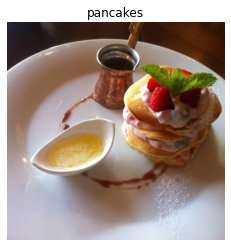

In [ ]:
# Plot one image from the dataset 
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [ ]:
# Function for scaling pixels from 0 to 1 (suitable for NN)
# Resize images to same shape (224,224)

def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, size=[img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[42 40 51]
  [41 39 50]
  [40 38 49]
  ...
  [50 23  6]
  [51 24  7]
  [51 24  7]]

 [[41 39 50]
  [41 39 50]
  [41 39 50]
  ...
  [47 20  3]
  [48 21  4]
  [49 22  5]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[41.127552  39.127552  50.127552 ]
  [40.642857  38.642857  49.642857 ]
  [40.285713  38.285713  49.285713 ]
  ...
  [48.92855   21.928549   4.500022 ]
  [47.7398    20.7398     3.7398005]
  [49.301044  22.301043   5.3010426]]

 [[40.642857  38.642857  49.642857 ]
  [42.9949    40.9949    51.9949   ]
  [41.85714   39.85714   50.85714  ]
  ...
  [49.127533  22.127531   4.699003 ]
  [47.862247  20.862246   3.8622465]
  [48.928574  21.928572   4.9285717]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


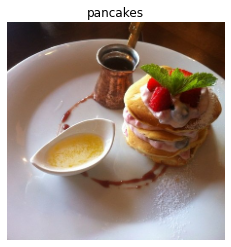

In [ ]:
# Plot preprocessed image 
preprocessed_img = preprocess_img(image, label)[0]
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Turn data into batches for memory efficiency 
# dataset -> map -> shuffle -> prefetch

# 1. Map preprocessing funtion to training data (batched tensors but be of same shape!)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# 2. Shuffle train data, batch it and prefetch it

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# 3. Map preporcessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# 4. Turn test data into batches (no need to shuffle testing data)

test_data=test_data.batch(32).prefetch(tf.data.AUTOTUNE)

train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
# Create callback functions 

# 1. TensorBorad callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# 2. ModelCheckpoint callback to save progress
path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)


In [ ]:
# Turn on mixed precision training
# Mixed precision -> uses a mix of float16 and float32 tensors to better use GPU's memory
# Uses tf.keras mixed precision API

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") 
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
### Model Building
# Use EfficientNetB0 as base model with frozen layers
# Functional model: input -> base model -> pooling -> output



from tensorflow.keras import layers

#base model - freeze model, train only top layer
input_shape=(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)  
base_model.trainable = False

# Create Functional Model

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name="pooling_layers")(x)
x = layers.Dense(len(class_names))(x) #outunt layer, one neuron per class

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) #activation of output layer must be separate so activation updates are float32
model = tf.keras.Model(inputs, outputs)


# Compile model

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Check out our model
model.summary()


16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layers (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                              

In [ ]:
# fit the feature extraction model
# Turn off all warning except for error

tf.get_logger().setLevel('ERROR')

#Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint]
                                                     )

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230124-171603


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - 184s 69ms/step - loss: 1.8231 - accuracy: 0.5577 - val_loss: 1.2169 - val_accuracy: 0.6830
Epoch 2/3
2368/2368 [==============================] - 159s 67ms/step - loss: 1.2939 - accuracy: 0.6661 - val_loss: 1.1260 - val_accuracy: 0.7039
Epoch 3/3
2368/2368 [==============================] - 158s 66ms/step - loss: 1.1444 - accuracy: 0.7017 - val_loss: 1.0857 - val_accuracy: 0.7132


In [ ]:
# Evaluate model
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 49s 61ms/step - loss: 1.0878 - accuracy: 0.7085


[1.0877827405929565, 0.7084752321243286]

In [ ]:
# Check models checkpoints
# Clone mode with reset weights -> load weights -> evaluate

# Clone the model we created - resets weights
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layers (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])


In [ ]:
# Evalaute cloned model with loaded weights
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 63s 77ms/step - loss: 1.7306 - accuracy: 0.5466


In [ ]:
# check if weights are the same as with original mode

import numpy as np
# assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check 

In [ ]:
### Save entire model to file

# # Create save path to drive 
save_dir = "drive/MyDrive/tensorflow/machine_vision_food/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
### Prapairing models layers for fine tuning

# Use saved model
loaded_saved_model = tf.keras.models.load_model(save_dir)

# Get a summary of our loaded model
loaded_saved_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layers (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Check if any layers are frozen

for layer in loaded_saved_model.layers:
  layer.trainable=True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layers True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check that models in base layer are trainable and using mixed precision 
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

In [ ]:
# Fine tuning a model of this size (200 layers using over 100k images) is presumed to take a long time
# Use early stoping to stop training when chosed performance metric stops imporivng
# Use ModelCheskpoint to save best performing model

# EarlyStoping callback, stop training if model's val_loss doesnt improve for 3 epochs

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3) # when val loss decreases for 3 epochs in a row, stop training


# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Create learning rate reduction callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, #reduce LR by a factor of 5
                                                 patience=2,
                                                 verbose=1, # print when LR is reduced
                                                 min_lr=1e-7)

In [ ]:
# Compile model

loaded_saved_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=["accuracy"])

In [ ]:
# start fine tuning (all layers)

history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230124-175544


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9218 - accuracy: 0.7530

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 379s 153ms/step - loss: 0.9218 - accuracy: 0.7530 - val_loss: 0.8371 - val_accuracy: 0.7693 - lr: 1.0000e-04


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.8399

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 361s 151ms/step - loss: 0.5786 - accuracy: 0.8399 - val_loss: 0.7745 - val_accuracy: 0.7913 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 317s 133ms/step - loss: 0.3349 - accuracy: 0.9045 - val_loss: 0.9287 - val_accuracy: 0.7767 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9471
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 317s 133ms/step - loss: 0.1769 - accuracy: 0.9471 - val_loss: 0.9874 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 320s 134ms/step - loss: 0.0363 - accuracy: 0.9917 - val_loss: 1.0348 - val_accuracy: 0.8008 - lr: 2.0000e-05


In [ ]:
# Save model to Google Drive 
loaded_saved_model.save("drive/MyDrive/tensorflow/machine_vision_food/")



/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
